In [2]:
import matplotlib.pyplot as plt
import numpy as np

import deepxde1 as dde
from deepxde1.backend import tf

Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow



Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)


2024-08-14 19:51:12.672554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-14 19:51:12.672635: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def heat_eq_exact_solution(x, t):
    """
    Returns the exact solution for a given x and t (for sinusoidal initial conditions).
    
    Parameters
    ----------
    x : np.ndarray
    t : np.ndarray
    """
    
    return np.exp(-(n**2*np.pi**2*a*t)/(L**2))*np.sin(n*np.pi*x/L)

In [4]:
def gen_exact_solution():
    """
    Generates exact solution for the heat equation for the given values of x and t.
    """
    
    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.)
    x_max, t_max = (L, 1.)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i],t[j])

    # Save solution:
    np.savez('heat_eq_data', x=x, t=t, usol=usol)
    data = np.load('heat_eq_data.npz')

In [5]:
def gen_testdata():
    """
    Import and preprocess the dataset with the exact solution.
    """
    
    # Load the data:
    data = np.load('heat_eq_data.npz')
    
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    
    return X, y

In [6]:
def main():

    def pde(x, y):
        """
        Expresses the PDE residual of the heat equation.        
        """
        dy_t = dde.grad.jacobian(y, x, i=0, j=1)
        dy_xx = dde.grad.hessian(y, x, i=0, j=0)
        return dy_t - a*dy_xx

    # Computational geometry:
    geom = dde.geometry.Interval(0, L)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    # Initial and boundary conditions:
    bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
    ic = dde.icbc.IC(
        geomtime, lambda x: np.sin(n*np.pi*x[:, 0:1]/L), lambda _, on_initial: on_initial
        )

    # Define the PDE problem and configurations of the network:
    data = dde.data.TimePDE(
        geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160, num_test=2540
    )
    net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    # Build and train the model:
    model.compile("yogi", lr=1e-3)
    model.train(epochs=20000)
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

    # Plot/print the results
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)
    X, y_true = gen_testdata()
    y_pred = model.predict(X)
    f = model.predict(X, operator=pde)
    print("Mean residual:", np.mean(np.absolute(f)))
    print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
    np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

/tmp/ipykernel_6960/755250868.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  usol[i][j] = heat_eq_exact_solution(x[i],t[j])
/home/ruslan/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/ruslan/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/ruslan/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance propertie

Compiling model...
'compile' took 0.000749 s

Training model...

Cause: could not parse the source code of <function main.<locals>.<lambda> at 0x7febb7049040>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function main.<locals>.<lambda> at 0x7febb7049040>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function main.<locals>.<lambda> at 0x7febb7049280>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimen

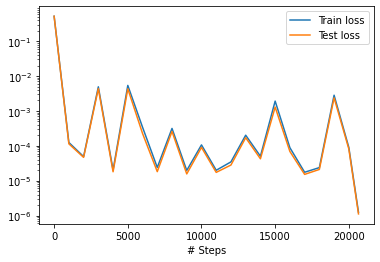

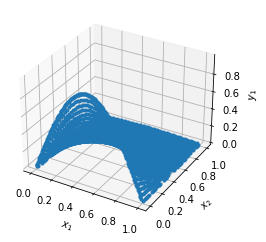

Mean residual: 0.0006778348
L2 relative error: 0.0009285058524941608


In [7]:
if __name__ == "__main__":

    # Problem parameters:
    a = 0.4 # Thermal diffusivity
    L = 1 # Length of the bar
    n = 1 # Frequency of the sinusoidal initial conditions

    # Generate a dataset with the exact solution (if you dont have one):
    gen_exact_solution()

    # Solve the equation:
    main()